Name: Bor-Sheng Huang   
Github Username: borsheng   
USC ID: 9589131162

## 1. Decision Trees as Interpretable Models

### (a) Download the Accute Inflamations data

In [1]:
import pandas as pd
import numpy as np
import csv
import math
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from scipy.stats import variation
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, ShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import xgboost as xgb

In [2]:
with open('../data/diagnosis.data', newline='', encoding='utf16') as f:
    reader = csv.reader(f, delimiter='\t')
    data = list(reader)
data = np.array(data)
data_first_col = np.array([item[0].replace(',', '.') for item in data])
data[:,0] = data_first_col

### (b) Build a decision tree on the whole data set and plot it.

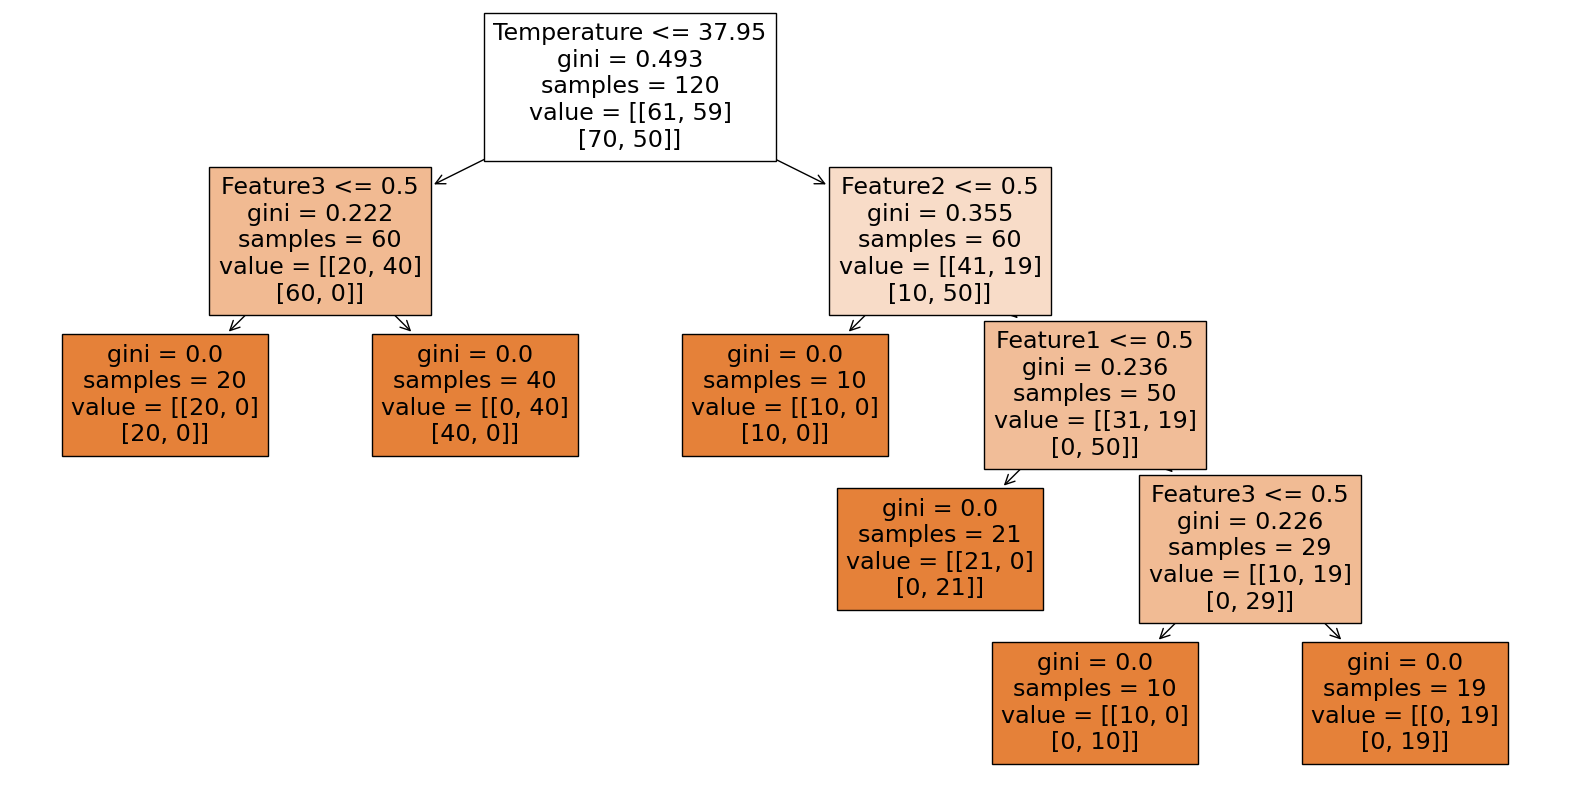

In [3]:
X = data[:,0:6]
y = data[:,6:8]
X[X=='yes'] = 1
X[X=='no'] = 0
y[y=='yes'] = 1
y[y=='no'] = 0
X = np.asarray(X, dtype = float)
y = np.asarray(y, dtype = float)

# train decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

# plot the tree
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, filled=True, feature_names=["Temperature"] + ["Feature" + str(i) for i in range(1, 6)], class_names=clf.classes_)
plt.show()

### (c) Convert the decision rules into a set of IF-THEN rules.

In [4]:
def tree_if_then(X):
    if X[0] <= 37.95:
        if X[3] <= 0.5:
            return [0.,0.]
        else:
            return [1.,0.]
    else:
        if X[2] <= 0.5:
            return [0.,0.]
        else:
            if X[4] <= 0.5:
                return [0.,1.]
            else:
                if X[3] <= 0.5:
                    return [0.,1.]
                else:
                    return [1.,1.]

X_predict = []

for i in X:
    X_predict.append(tree_if_then(i))

### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

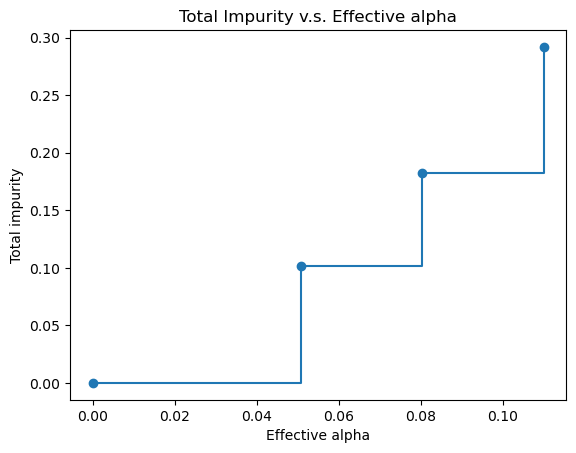

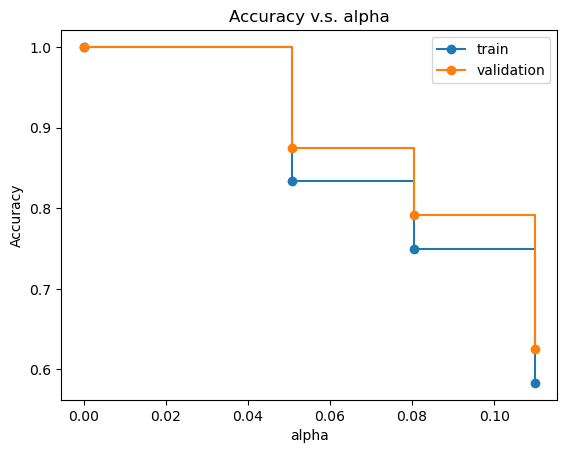

Selected alpha with best validation score: 0.0


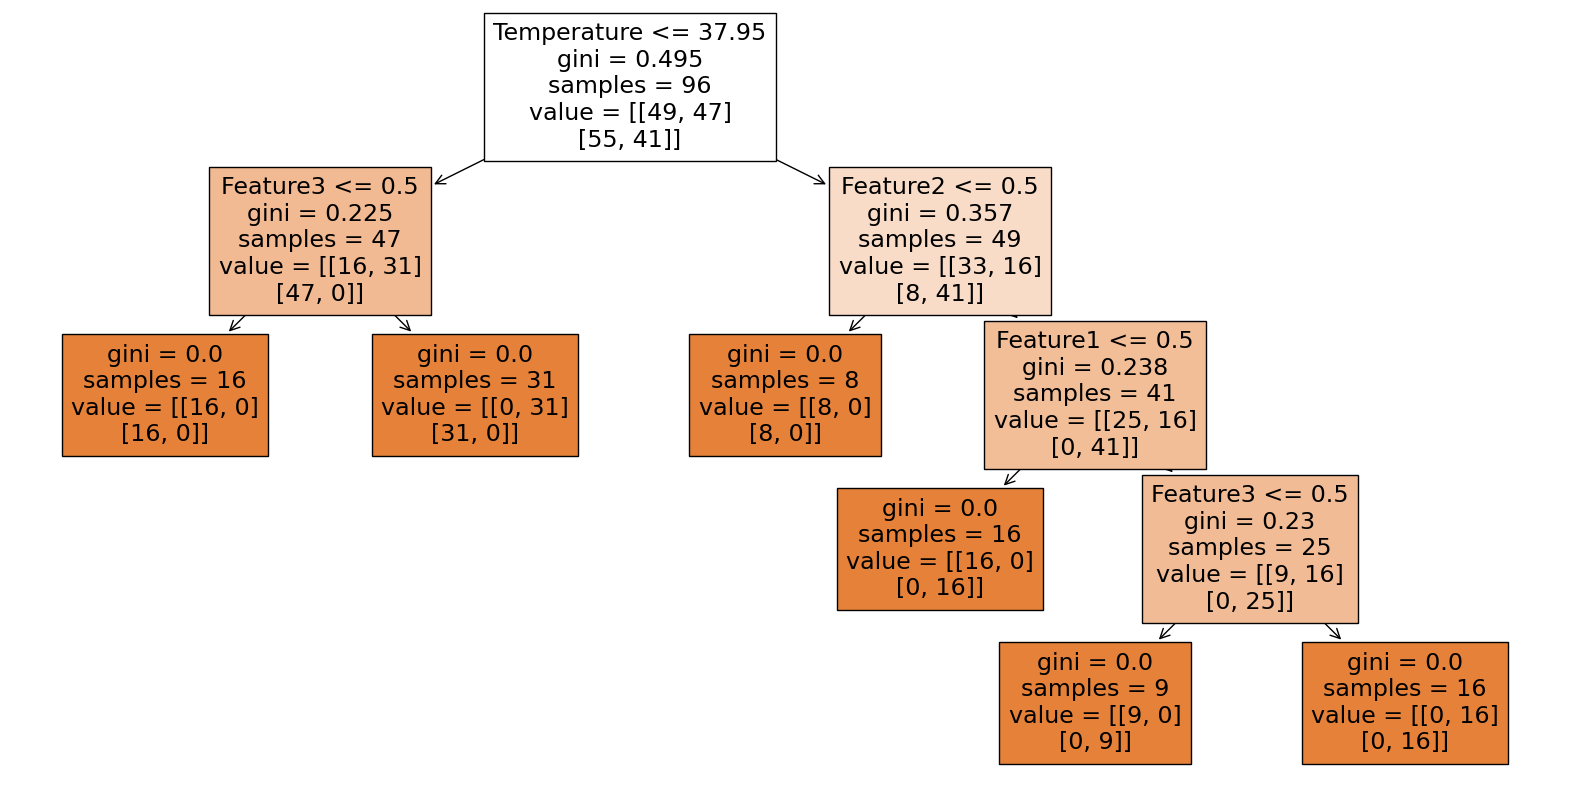

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# initial tree
clf = tree.DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# plot impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity")
ax.set_title("Total Impurity v.s. Effective alpha")

# create trees for each alpha
clfs = [tree.DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train) for alpha in ccp_alphas]
# remove the last tree which is the trivial tree with only one node
clfs = clfs[:-1]

# plot scores
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy v.s. alpha")
ax.plot(ccp_alphas[:-1], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], val_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()
plt.show()

best_idx = np.argmax(val_scores)
best_clf = clfs[best_idx]
print(f"Selected alpha with best validation score: {ccp_alphas[best_idx]}")

# plot the best tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_clf, filled=True, feature_names=["Temperature"] + ["Feature" + str(i) for i in range(1, 6)])
plt.show()

## 2. The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data

In [6]:
sio = StringIO(open('../data/communities.data').read().replace('?',''))

df = pd.read_csv(sio, header=None)

df_train = df.iloc[0:1495,:]
df_test = df.iloc[1495:,:]

### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [7]:
df_train_drop = df_train.drop(df_train.columns[:5], axis=1)
df_test_drop = df_test.drop(df_test.columns[:5], axis=1)

# use mean imputation
imputer = SimpleImputer(strategy="mean")
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train_drop), columns=df_train_drop.columns)
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test_drop), columns=df_test_drop.columns)

df_imputed = pd.concat([df_train_imputed, df_test_imputed])
df_imputed = df_imputed.reset_index(drop=True)
df_imputed.columns = range(df_imputed.shape[1])
df_imputed

0     1     2     3     4     5     6     7     8     9    ...   113  \
0     0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...  0.12   
1     0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  ...  0.02   
2     0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  ...  0.01   
3     0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  ...  0.02   
4     0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  ...  0.04   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1989  0.01  0.40  0.10  0.87  0.12  0.16  0.43  0.51  0.35  0.30  ...  0.01   
1990  0.05  0.96  0.46  0.28  0.83  0.32  0.69  0.86  0.73  0.14  ...  0.02   
1991  0.16  0.37  0.25  0.69  0.04  0.25  0.35  0.50  0.31  0.54  ...  0.08   
1992  0.08  0.51  0.06  0.87  0.22  0.10  0.58  0.74  0.63  0.41  ...  0.03   
1993  0.20  0.78  0.14  0.46  0.24  0.77  0.50  0.62  0.40  0.17  ...  0.11   

       114   115       116       117       118       119   120       121   122  
0     0.26  0.20  0.060000  0.040000  0.900000  0.500000  0.32  0.140000  0.20  
1     0.12  0.45  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.67  
2     0.21  0.02  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.43  
3     0.39  0.28  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.12  
4     0.09  0.02  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.03  
...    ...   ...       ...       ...       ...       ...   ...       ...   ...  
1989  0.28  0.05  0.160500  0.065375  0.655375  0.406250  0.00  0.208000  0.09  
1990  0.37  0.20  0.160500  0.065375  0.655375  0.406250  0.00  0.208000  0.45  
1991  0.32  0.18  0.080000  0.060000  0.780000  0.000000  0.91  0.280000  0.23  
1992  0.38  0.33  0.020000  0.020000  0.790000  0.000000  0.22  0.180000  0.19  
1993  0.30  0.05  0.080000  0.040000  0.730000  0.500000  1.00  0.130000  0.48  

[1994 rows x 123 columns]

### (c) Plot a correlation matrix for the features in the data set.

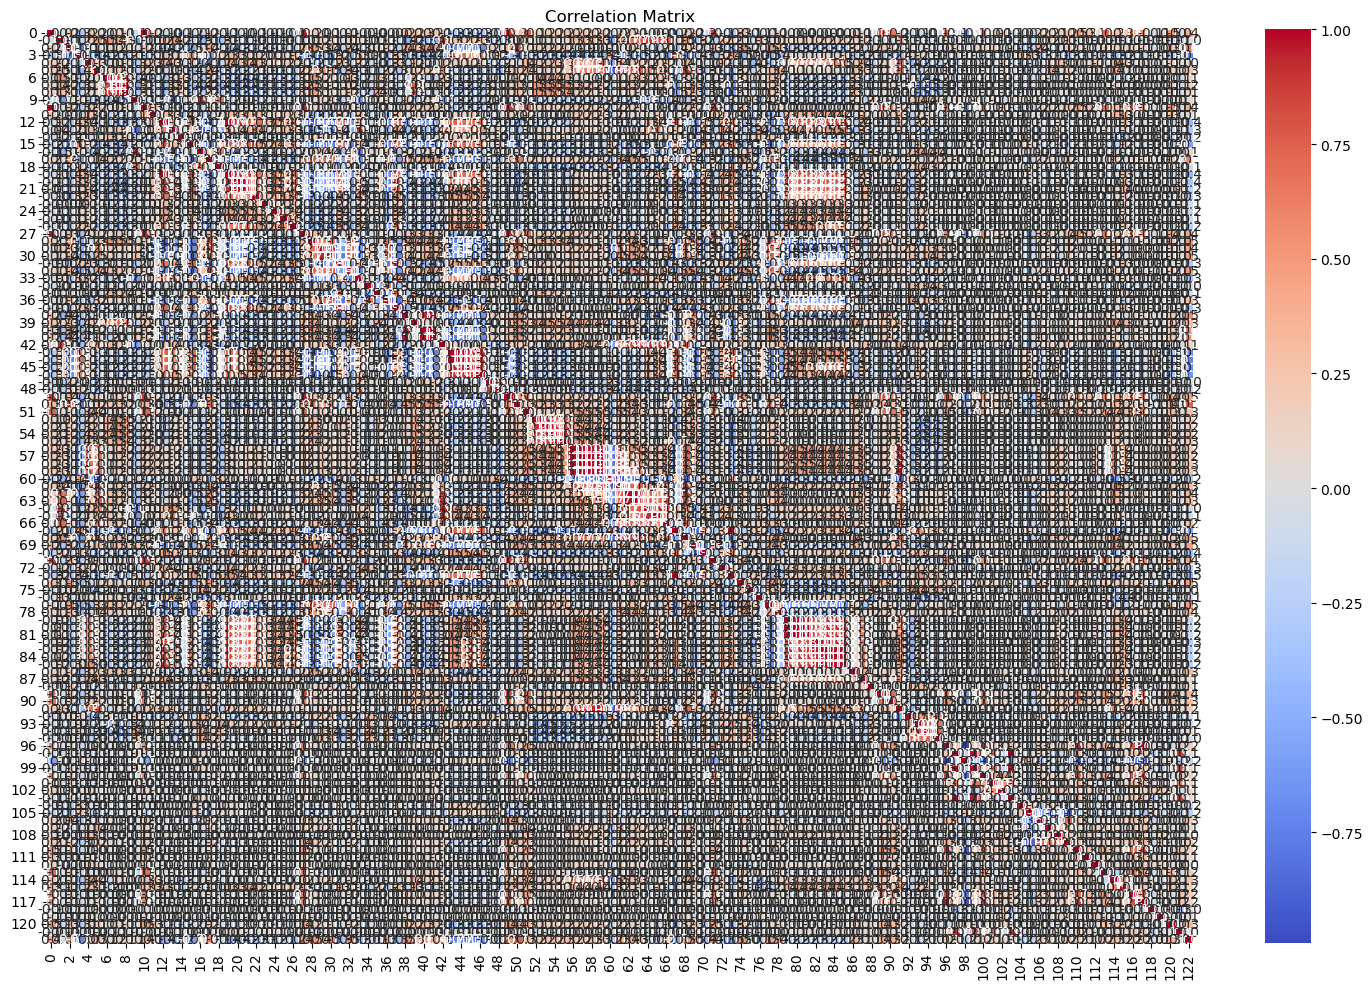

In [8]:
correlation_matrix = df_imputed.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [9]:
mean_values = df_imputed.mean()
std_values = df_imputed.std()
CV = (std_values / mean_values).values
print('CV:\n', CV)

CV:
 [2.20350254 0.3532983  1.4109204  0.32378156 1.35916219 1.61427779
 0.36583987 0.29069289 0.49516051 0.42344171 2.00174364 0.63884887
 0.57975339 0.32771006 0.70003012 0.35923995 0.36851263 0.6990305
 0.34963908 0.52773189 0.54563343 0.50755219 0.589469   0.80968509
 0.60619385 0.67064807 0.47395972 2.30496971 0.75398017 0.67560022
 0.52828627 0.57840084 0.5561328  0.34732725 0.51058034 0.39822568
 0.50846131 0.42210586 0.39558337 0.40381162 0.3592727  0.37146815
 0.31695475 0.33061114 0.33247588 0.32942584 0.32855095 0.33624845
 0.33272212 2.99419645 0.91980289 2.90049716 0.68420109 0.58489027
 0.50490986 0.45566604 1.3001003  1.29763181 1.28123297 1.28403377
 0.28867317 1.4590666  0.73453473 0.75710873 0.36691384 0.31940729
 0.46845379 0.35031616 1.12719959 0.34837064 0.81088779 1.95877973
 0.26964697 0.33754097 1.06474242 0.43611899 0.47041143 0.91821097
 0.84874387 0.84788021 0.87874984 0.87473297 0.63318641 0.56188436
 0.58701424 0.55559247 0.34582952 0.41639117 0.47693324 3.

### (e) Pick [128^0.5] features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

/Users/erichuang/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


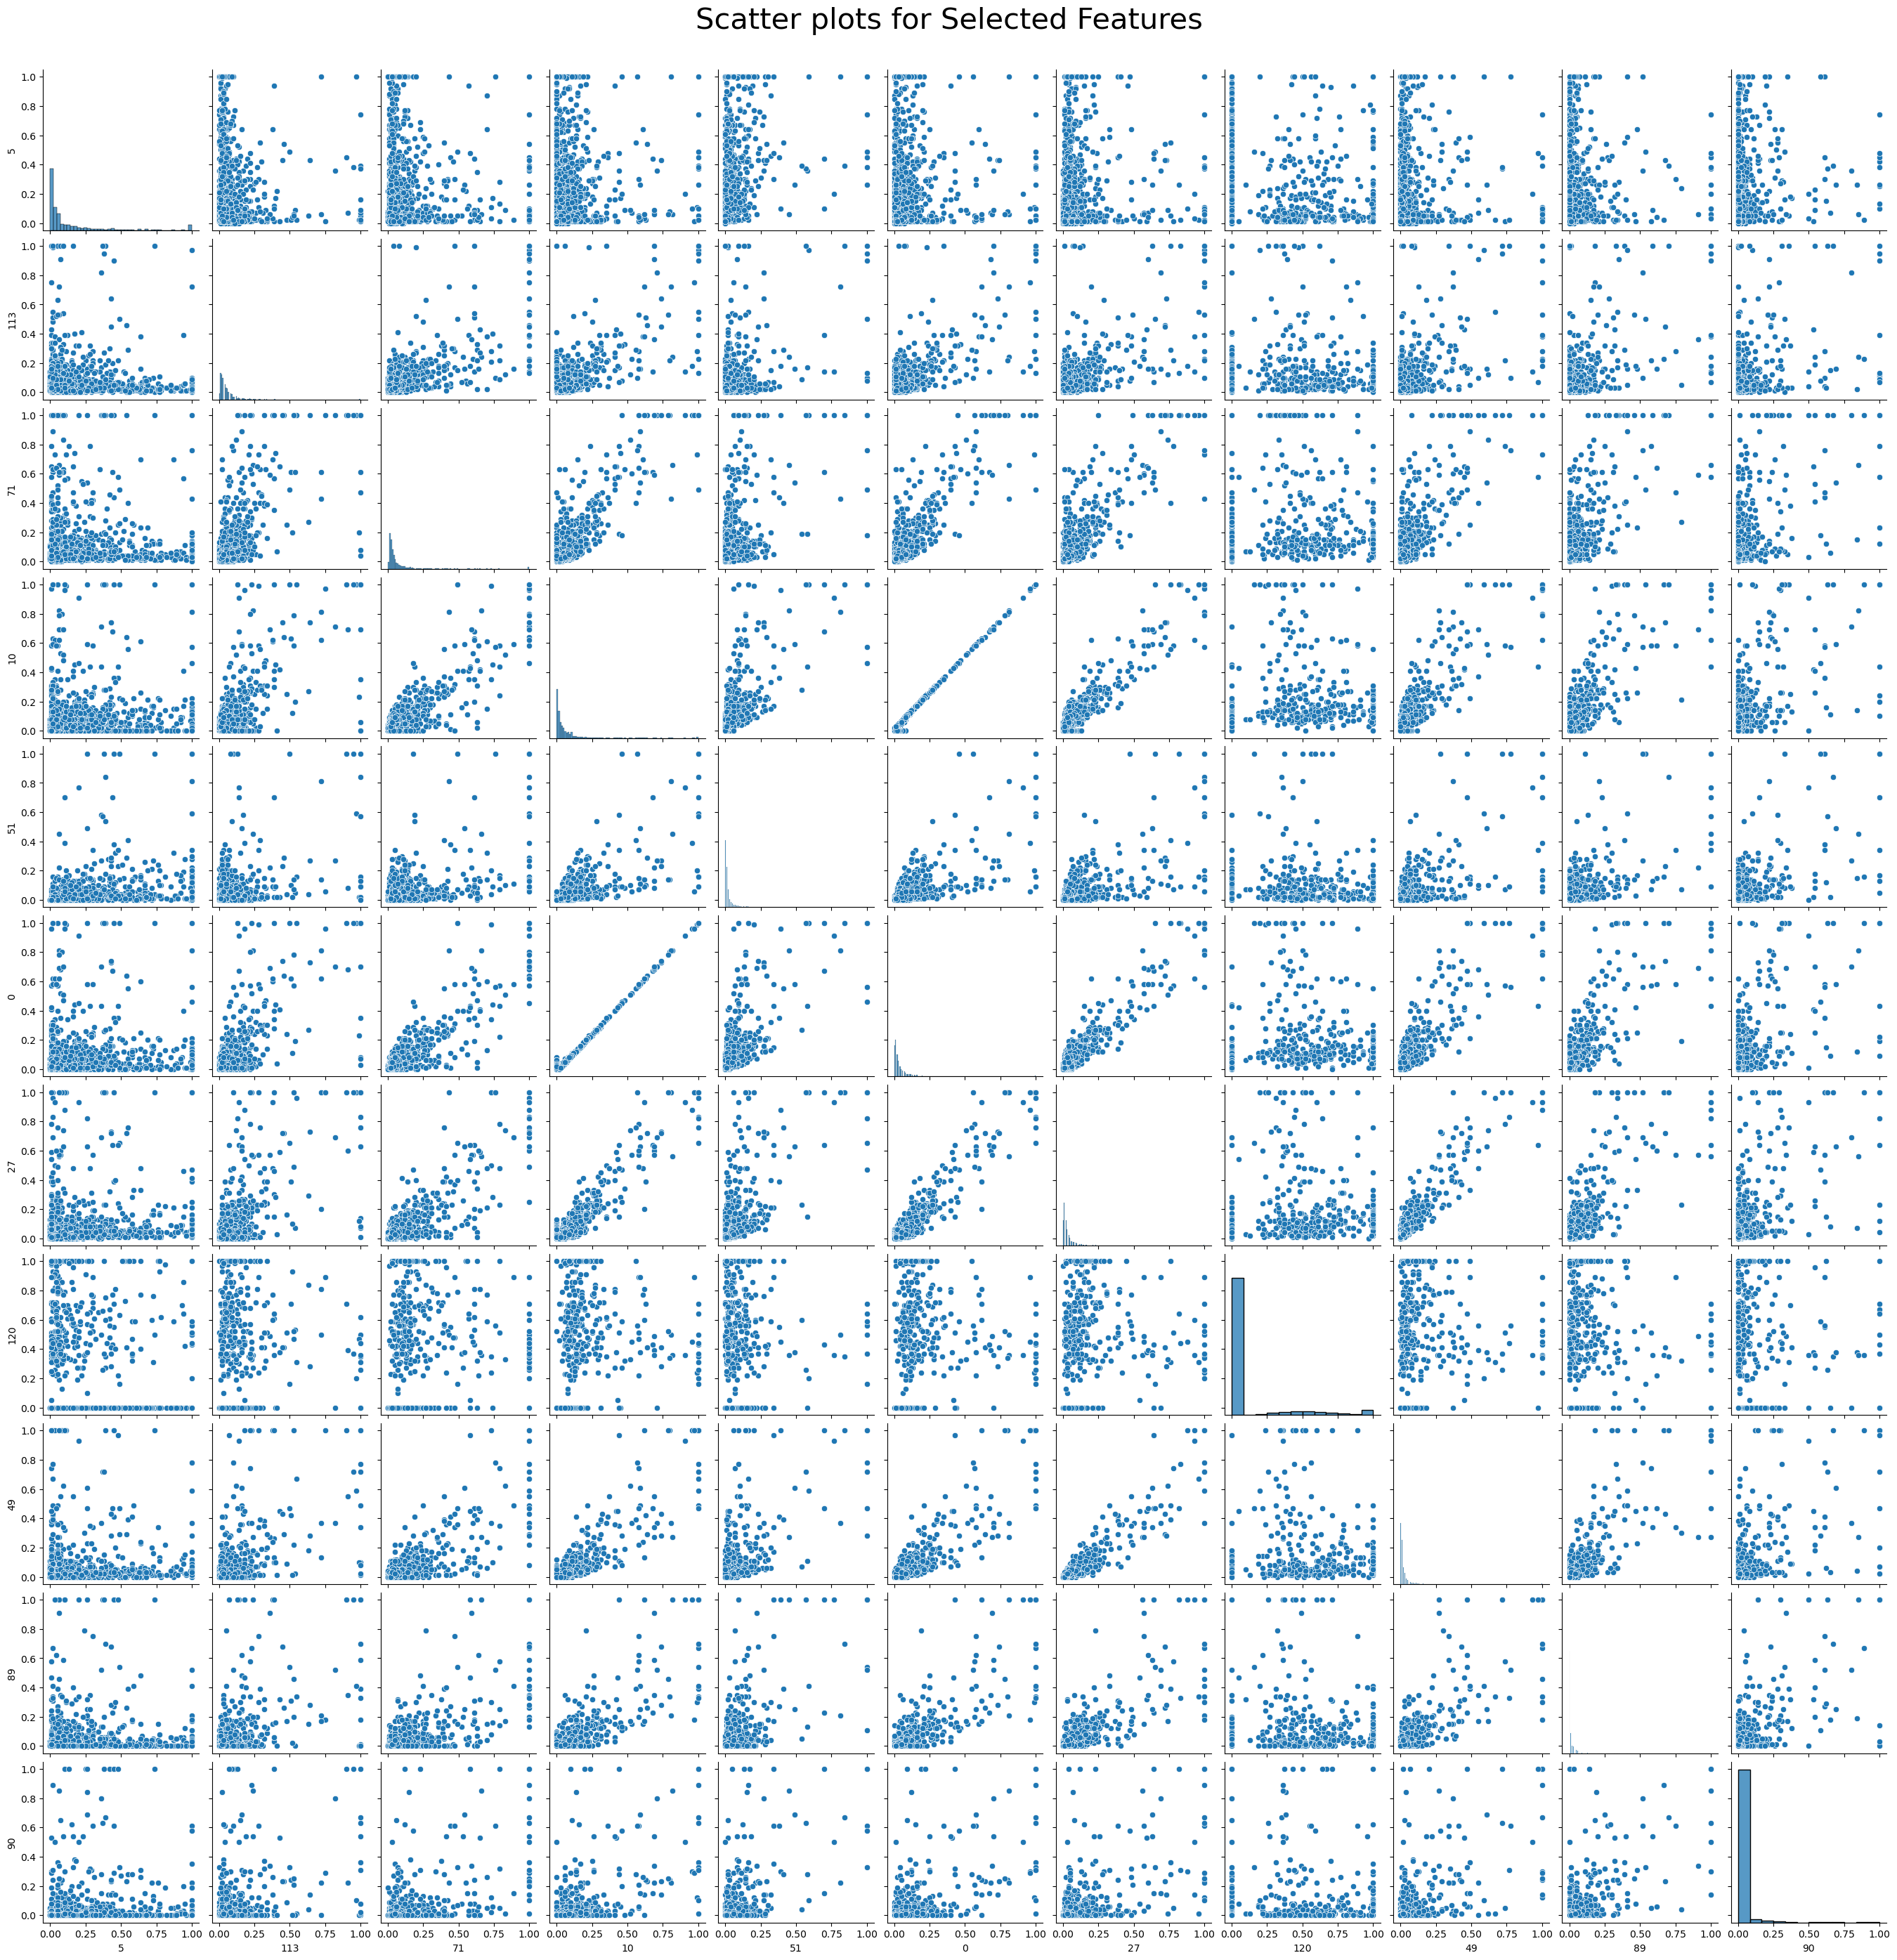

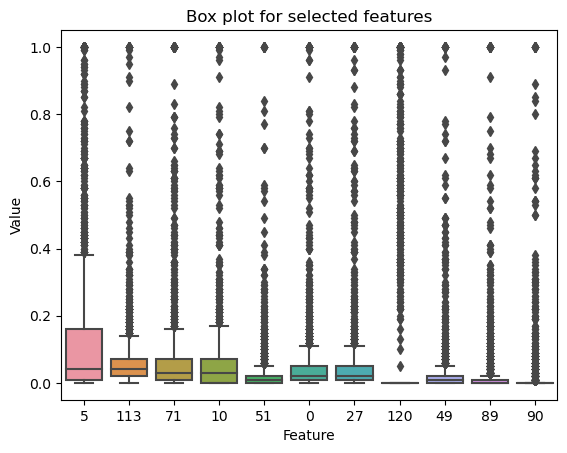

In [10]:
n = math.floor(math.sqrt(128))

# get the indices of the 'n' features with the highest CV values
index = np.argpartition(CV, -n)[-n:]
df_selected = df_imputed.iloc[:, index]

# plot scatterplots of the selected features
scatterplots = sns.pairplot(df_selected)
scatterplots.fig.suptitle("Scatter plots for Selected Features", y=1.02, fontsize=30)
plt.show()

# plot boxplots of the selected features
sns.boxplot(data=df_selected)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Box plot for selected features')
plt.show()

We can see that these 11 features are mostly highly correlated.

### (f) Fit a linear model using least squares to the training set and report the test error.

In [11]:
# split the data to x and y
X_train = df_train_imputed.iloc[:, :-1]
y_train = df_train_imputed.iloc[:, -1]
X_test = df_test_imputed.iloc[:, :-1]
y_test = df_test_imputed.iloc[:, -1]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print(f"Test Error using linear model: {test_error}")

Test Error using linear model: 1.928489737009607e+16


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [12]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, store_cv_values=True))

# use cross-validation
cv = ShuffleSplit(n_splits=5, random_state=42)
cv_results = cross_validate(ridge_cv, X_train, y_train, cv=cv, 
                            scoring="neg_mean_squared_error",
                            return_train_score=True, 
                            return_estimator=True, 
                            n_jobs=2)

# extract the optimal alphas from each fold and take the mean
best_alpha = np.mean([est[-1].alpha_ for est in cv_results["estimator"]])

final_ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
final_ridge_model.fit(X_train, y_train)
y_pred = final_ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Test error using the ridge regression with chosen alpha ({best_alpha:.5f}): {mse:.5f}')

Test error using the ridge regression with chosen alpha (111.69172): 0.01748


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [13]:
alphas = 10**np.linspace(10, -2, 100) * 0.5
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=100000)

# without standardizing
lasso_cv.fit(X_train, y_train)
pred_y = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, pred_y)
selected_vars = np.where(lasso_cv.coef_ != 0)[0]
print('Without standardizing:')
print('Test error using Lasso with chosen alpha:', mse)
print('Variables selected:', selected_vars)
print('-'*95)

# with standardized features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
lasso_cv.fit(scaled_X_train, y_train)
pred_y = lasso_cv.predict(scaled_X_test)
mse_scaled = mean_squared_error(y_test, pred_y)
selected_vars_scaled = np.where(lasso_cv.coef_ != 0)[0]
print('With standardized features:')
print('Test error using Lasso with standardized features:', mse_scaled)
print('Variables selected:', selected_vars_scaled)
print('-'*95)

if mse_scaled < mse:
    print('The test error for the dataset with standardized features is lower.')
else:
    print('The test error for the original dataset is lower.')

Without standardizing:
Test error using Lasso with chosen alpha: 0.018805364920055027
Variables selected: [ 3 11 38 44 50 68 71 74]
-----------------------------------------------------------------------------------------------
With standardized features:
Test error using Lasso with standardized features: 0.01736636001365389
Variables selected: [  2   3   7  11  15  17  18  24  38  44  48  50  68  69  71  72  74  86
  88  90  91 101 102 119 120]
-----------------------------------------------------------------------------------------------
The test error for the dataset with standardized features is lower.


### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [14]:
# PCA and scalae together in a pipeline
pipe = make_pipeline(StandardScaler(), PCA())
X_pca_train = pipe.fit_transform(X_train)

# use cross-validation
mse_scores = []
for n_components in range(1, scaled_X_train.shape[1] + 1):
    regr = LinearRegression()
    score = -cross_val_score(regr, X_pca_train[:, :n_components], y_train, cv=10, scoring="neg_mean_squared_error").mean()
    mse_scores.append(score)

best_n_components = np.argmin(mse_scores) + 1

# use the best model
best_regr = LinearRegression()
best_regr.fit(X_pca_train[:, :best_n_components], y_train)

X_pca_test = pipe.transform(X_test)[:, :best_n_components]
y_pred = best_regr.predict(X_pca_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f"M (Optimal number of components): {best_n_components}")
print(f"Test error using PCR model with M: {mse_test}")

M (Optimal number of components): 95
Test error using PCR model with M: 0.01833843867965863


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [15]:
param_grid = { 'reg_alpha': np.logspace(-5, 2, 20) }

# use GridSearchCV to find best alpha
model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(scaled_X_train, y_train)
best_alpha = grid_search.best_params_['reg_alpha']
best_mse = -grid_search.best_score_

pred_y = grid_search.best_estimator_.predict(scaled_X_test)
print('Best alpha (L1 regularization term):', best_alpha)
print('Test error using XGBoost for the testing dataset:', mean_squared_error(y_test, pred_y))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha (L1 regularization term): 3.359818286283781
Test error using XGBoost for the testing dataset: 0.01760601474711291
